In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Uncomment if you want to load raw `en` tweets
# df = pd.read_csv('../data/tweets_en.csv')
# df = df.drop('index', axis=1)

# Load below to get sentiment processed tweets from 2016-2019
df = pd.read_csv('../data/tweets_en_2016_2019_sentiment.csv')
df = df.drop(['neg_sent', 'neu_sent', 'pos_sent', 'sentiment'], axis=1)
df = df.dropna().reset_index(drop=True)

for col in ['replies', 'likes', 'retweets']:
    df[col] = pd.to_numeric(df[col])

/var/folders/y1/pm6_lt111h92v74z5vt3_vhh0000gn/T/ipykernel_84120/2203971960.py:6: DtypeWarning: Columns (2,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/tweets_en_2016_2019_sentiment.csv')


In [3]:
# No Missing values
df.isnull().values.ravel().sum()

0

We only want to analyse data from `2016-01-01` to `2019-03-29` because of the data volume.

In [4]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df.sort_values(by=['date'], axis=0, inplace=True, ignore_index=True)
df.reset_index(inplace=True, drop=True)
df = df[
         (df['date']>=datetime.strptime('2016-01-01', '%Y-%m-%d').date())&
         (df['date']<=datetime.strptime('2019-03-29', '%Y-%m-%d').date())
     ].reset_index(drop=True)

Let us also merge the Bitcoin price (Closing Price) of each day to the above tweets data so that we can better analyse it.

In [5]:
btc_price = pd.read_csv('../data/BTC-USD.csv')
btc_price['Date'] = pd.to_datetime(btc_price['Date']).dt.date
btc_price = btc_price[['Date', 'Close']]
btc_price.columns = ['date', 'btc_price']

btc_price.head()

,date,btc_price
0,2016-01-01,434.334015
1,2016-01-02,433.437988
2,2016-01-03,430.010986
3,2016-01-04,433.091003
4,2016-01-05,431.959991


In [6]:
df = df.join(btc_price.set_index('date'), on='date', validate='m:1', how='left')

In [7]:
df.shape

(2327223, 10)

In [8]:
df.head()

,user,timestamp,replies,likes,retweets,text,tweet_lang,date,textblob_sentiment,btc_price
0,ProjectCoin,2016-01-01 07:54:18+00,0.0,0.0,1.0,LIVE: Profit = $419.17 (4.99 %). BUY B20.42 $...,en,2016-01-01,positive,434.334015
1,priceofreddcoin,2016-01-01 13:00:32+00,0.0,0.0,0.0,#RDD / #BTC on the exchanges:Cryptsy: 0.000000...,en,2016-01-01,neutral,434.334015
2,TickerCrypto,2016-01-01 12:20:31+00,0.0,0.0,0.0,$432.39 at 13:15 UTC [24h Range: $423.12 - $43...,en,2016-01-01,neutral,434.334015
3,TickerCrypto,2016-01-01 10:04:54+00,0.0,0.0,0.0,#Bitcoin last tradebtcecom $428.00cryptsy $413...,en,2016-01-01,neutral,434.334015
4,ProjectCoin,2016-01-01 17:50:19+00,0.0,0.0,0.0,LIVE: Profit = $404.23 (4.81 %). BUY B20.42 $...,en,2016-01-01,positive,434.334015


In [9]:
df.dtypes

user                   object
timestamp              object
replies               float64
likes                 float64
retweets              float64
text                   object
tweet_lang             object
date                   object
textblob_sentiment     object
btc_price             float64
dtype: object

## Exploratory Data Analysis

Analysing raw data of English tweets during 3 years of time.

Let's plot the trend of replies, likes and retweets from `2016` to `2019`.

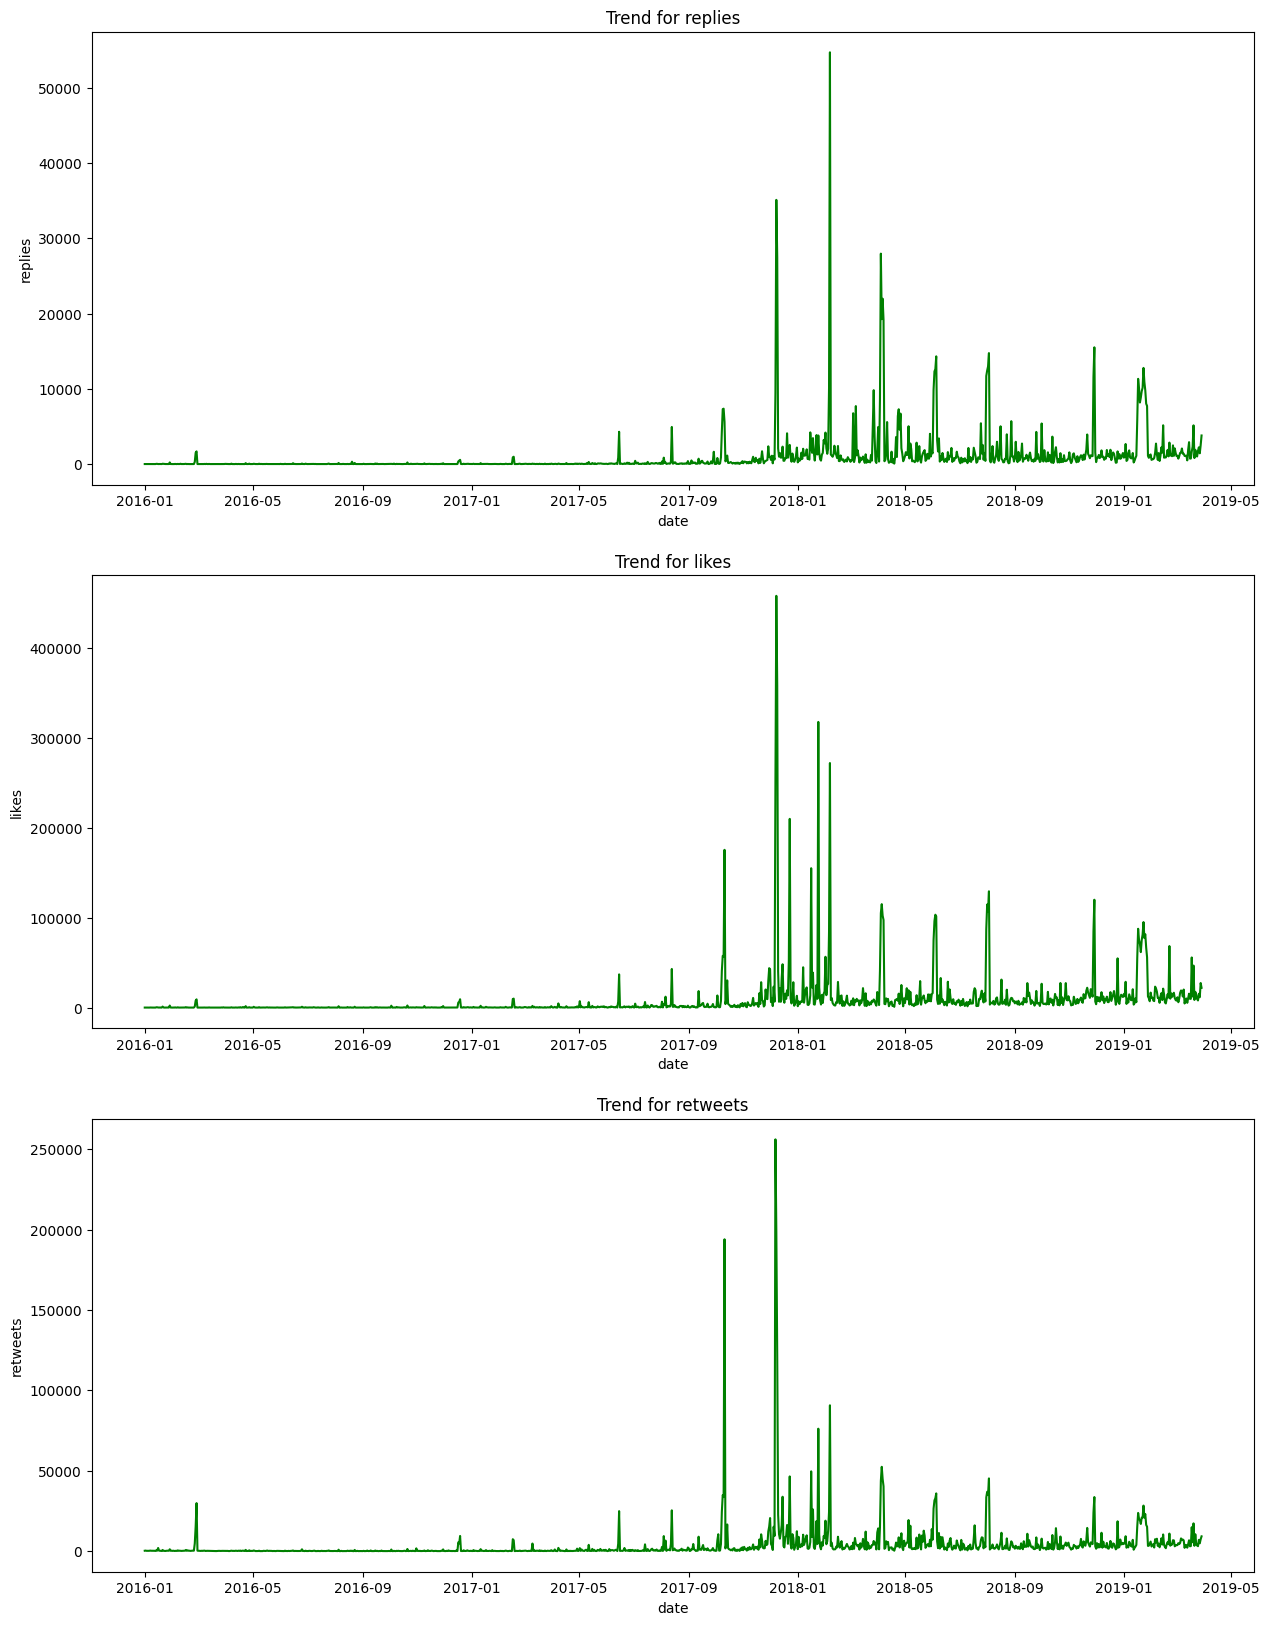

In [10]:
trend_cols = ['replies', 'likes', 'retweets']
fig, axs = plt.subplots(len(trend_cols), figsize=(15, 20))

i = 0
for col in trend_cols:
    tmp = df[['date', col]].groupby(['date']).sum().reset_index()
    axs[i].plot(tmp['date'], tmp[col], color='green')
    axs[i].set_xlabel('date')
    axs[i].set_ylabel(col)
    axs[i].set_title('Trend for {}'.format(col))
    i += 1

Let us also check daily tweet volume.

(0.0, 10000.0)

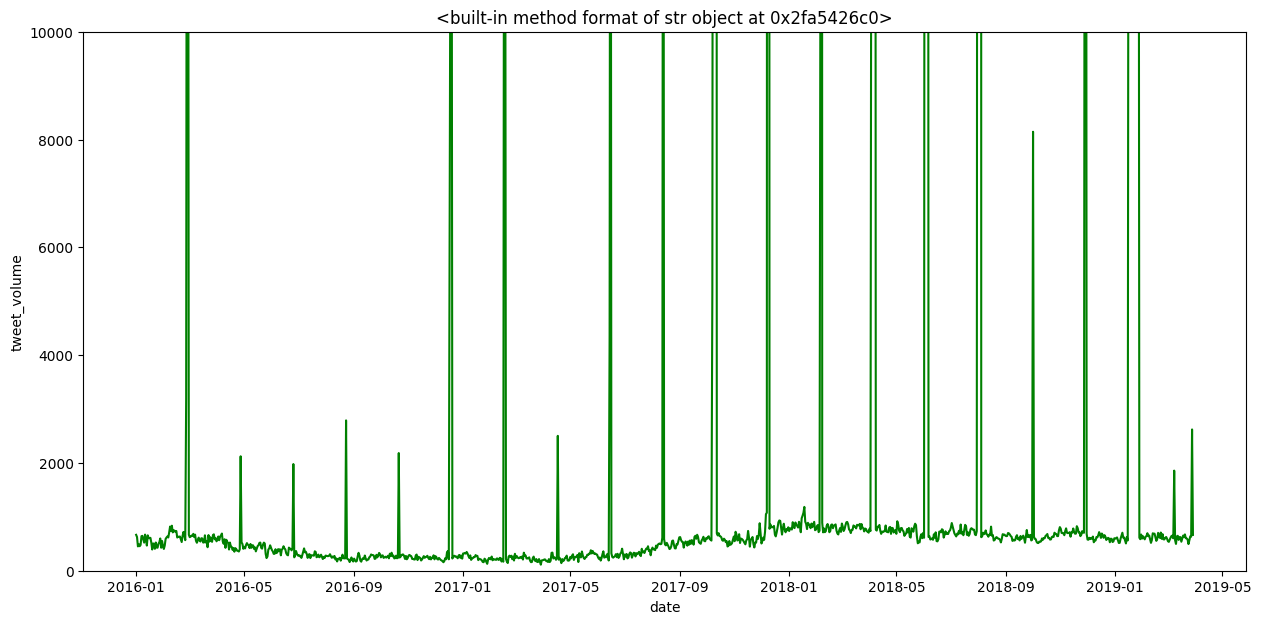

In [11]:
tweet_volume = df[['date', 'text']].groupby('date').count().reset_index()
tweet_volume.columns = ['date', 'tweet_volume']

plt.figure(figsize=(15,7))
plt.plot(tweet_volume['date'], tweet_volume['tweet_volume'], color='green')
plt.xlabel('date')
plt.ylabel('tweet_volume')
plt.title('Trend for Tweet Volume'.format)
plt.ylim(top=10000, bottom=0)

You can see that there are some days on which the number of tweets shoot up in the above plot. We expect that these days would have high fluctuation in bitcoin prices.

Let us also look at the number of likes on each day. We have already plotted the number of likes, but let us look at the number of tweets with likes >0, >10, >100, >1000.

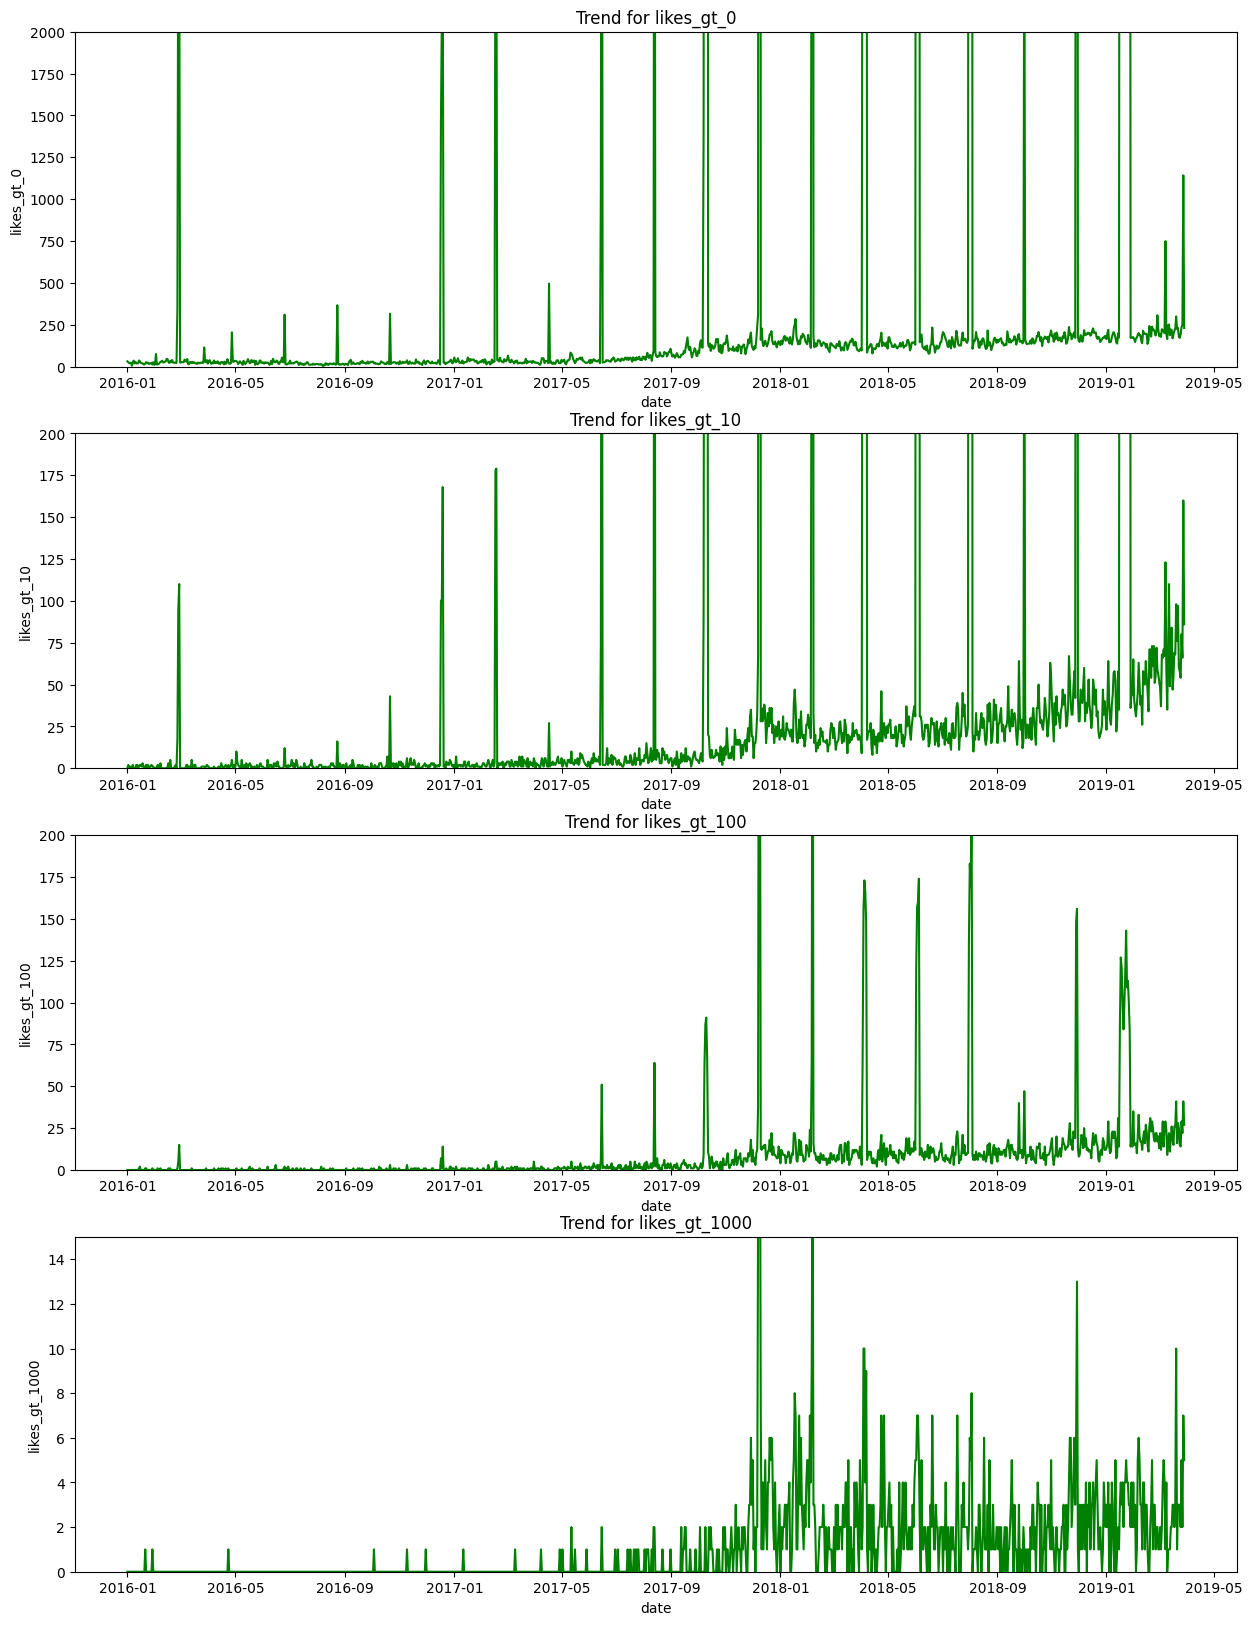

In [12]:
pd.options.mode.chained_assignment = None  # default='warn'

likes_volume = df[['date', 'likes']]

likes_volume['likes_gt_0'] = np.where(likes_volume["likes"]>0,1,0)
likes_volume['likes_gt_10'] = np.where(likes_volume["likes"]>10,1,0)
likes_volume['likes_gt_100'] = np.where(likes_volume["likes"]>100,1,0)
likes_volume['likes_gt_1000'] = np.where(likes_volume["likes"]>1000,1,0)

likes_volume = likes_volume[
    ['date', 'likes_gt_0', 'likes_gt_10', 'likes_gt_100', 'likes_gt_1000']
].groupby(
    ['date']
).agg({
       'likes_gt_0':'sum',
       'likes_gt_10':'sum',
       'likes_gt_100':'sum',
       'likes_gt_1000':'sum'
    }).reset_index()

likes_trend_cols = ['likes_gt_0', 'likes_gt_10', 'likes_gt_100', 'likes_gt_1000']
y_top_lim = [2000, 200, 200, 15]
fig, axs = plt.subplots(len(likes_trend_cols), figsize=(15, 20))

i = 0
for col in likes_trend_cols:
    axs[i].plot(likes_volume['date'], likes_volume[col], color='green')
    axs[i].set_xlabel('date')
    axs[i].set_ylabel(col)
    axs[i].set_title('Trend for {}'.format(col))
    axs[i].set_ylim(top=y_top_lim[i], bottom=0)
    i += 1

We can see that all the likes trend increases from `2016` to `2019`. It is also similar to the bitcoin hype among the people of the world.

Let us also analyse the positive, negative and neutral tweets on each day.

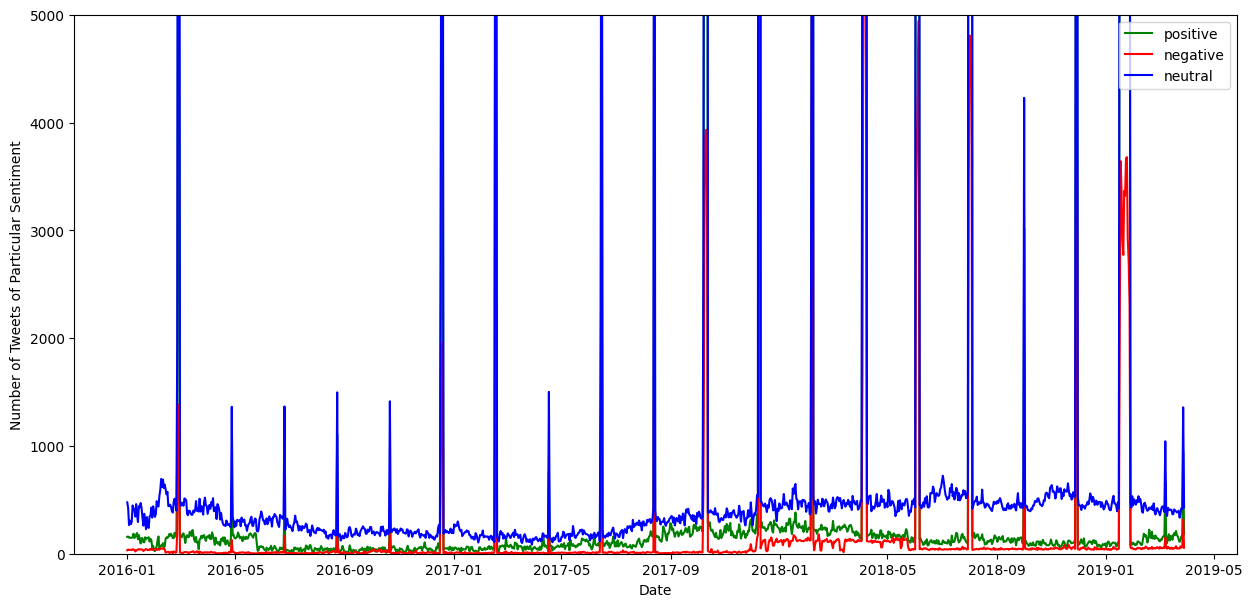

In [13]:
sent_volume = df[['date', 'textblob_sentiment']]

sent_volume['pos_sent'] = np.where(sent_volume["textblob_sentiment"]=='positive',1,0)
sent_volume['neg_sent'] = np.where(sent_volume["textblob_sentiment"]=='negative',1,0)
sent_volume['neu_sent'] = np.where(sent_volume["textblob_sentiment"]=='neutral',1,0)

sent_volume = sent_volume[
    ['date', 'pos_sent', 'neg_sent', 'neu_sent']
].groupby(
    ['date']
).agg({
       'pos_sent':'sum',
       'neg_sent':'sum',
       'neu_sent':'sum'
    }).reset_index()

plt.figure(figsize=(15,7))
plt.plot(sent_volume['date'], sent_volume['pos_sent'], label='positive', color='green')
plt.plot(sent_volume['date'], sent_volume['neg_sent'], label='negative', color='red')
plt.plot(sent_volume['date'], sent_volume['neu_sent'], label='neutral', color='blue')
plt.legend()
plt.ylim(top=5000, bottom=0)
plt.xlabel('Date')
plt.ylabel('Number of Tweets of Particular Sentiment')
plt.show()

We can see in the above plot that the the number of neutral tweets are higher than number of negative and positive tweets on almost everyday. From this, inference can be made that most people are writing informational or neutral opinions for Bitcoins.

Let us also try to observe if people are talking about Bitcoin more on a specific days of the week.

In [14]:
df['day'] = pd.to_datetime(df['timestamp']).dt.day_name()

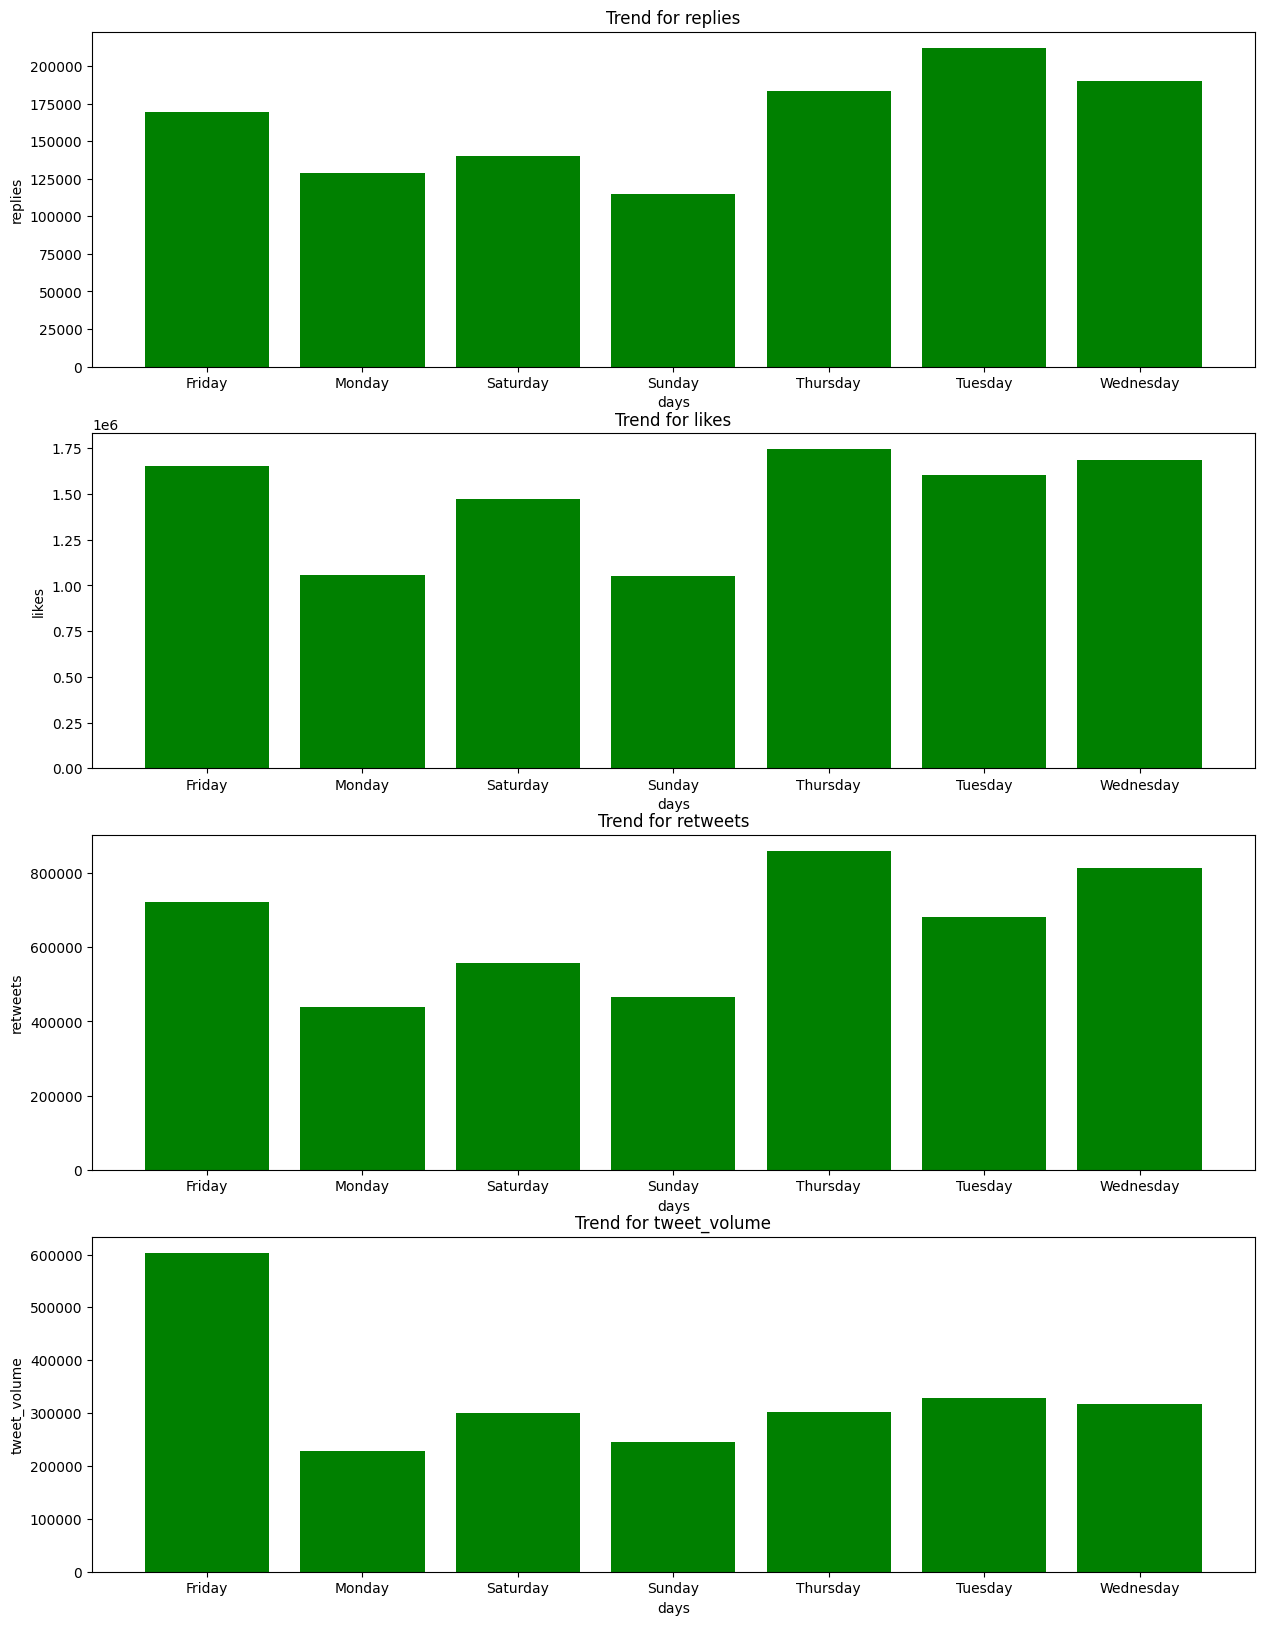

In [15]:
dow_volume = df[
    ['day', 'replies', 'likes', 'retweets', 'text']
].groupby(
    'day'
).agg({
    'replies': 'sum',
    'likes': 'sum',
    'retweets': 'sum',
    'text': 'count'
}).sort_values(by='day').reset_index()

dow_volume.columns = ['day', 'replies', 'likes', 'retweets', 'tweet_volume']

day_trend_cols = ['replies', 'likes', 'retweets', 'tweet_volume']
fig, axs = plt.subplots(len(day_trend_cols), figsize=(15, 20))

i = 0
for col in day_trend_cols:
    axs[i].bar(dow_volume['day'], dow_volume[col], color='green')
    axs[i].set_xlabel('days')
    axs[i].set_ylabel(col)
    axs[i].set_title('Trend for {}'.format(col))
    i += 1

We can see in the above analysis that tweet volume is significantly high on Fridays as compared to other days. For other parameters (likes, replies, etc.), the trend is inconclusive of any important inference.

Let us also do similar analysis on hour of the day. It will help us understand whether there is any specific time in a day when people tend to tweet more or respond more to other tweets.

In [16]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

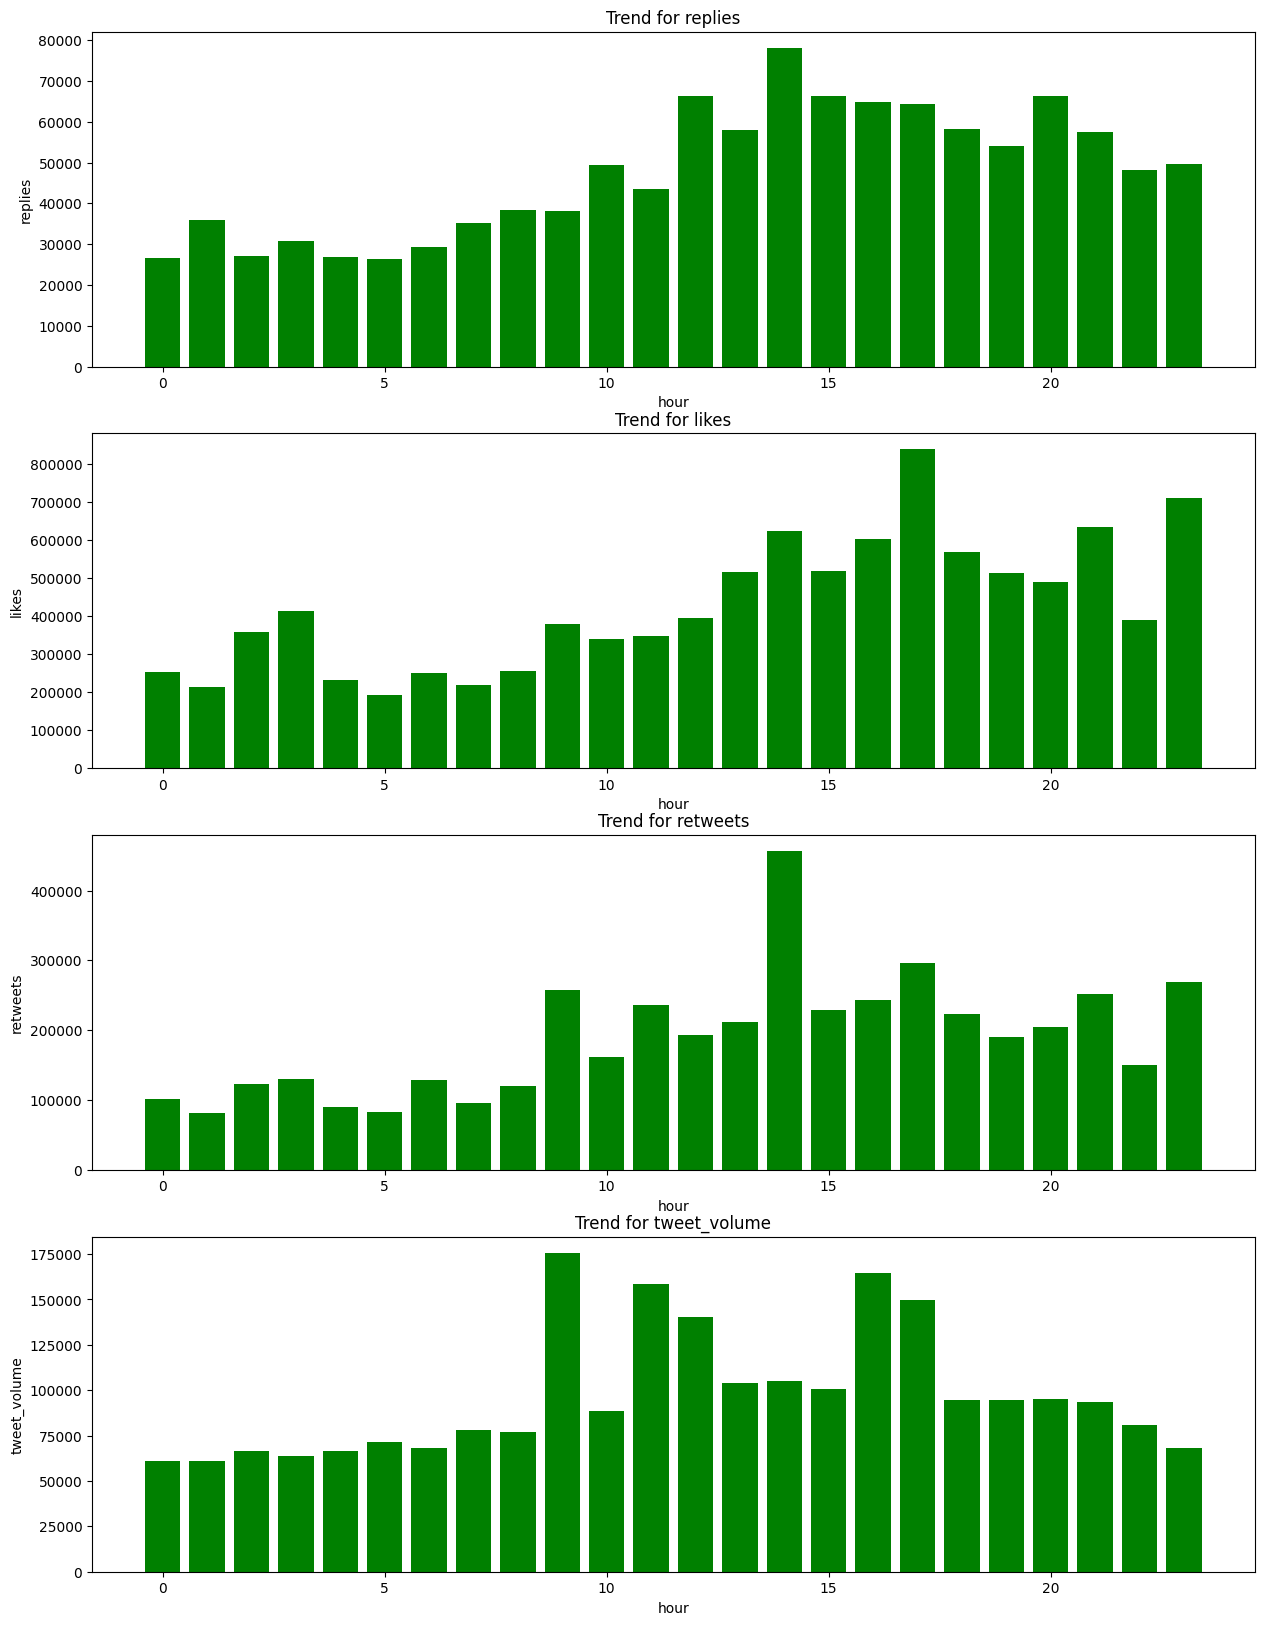

In [17]:
hr_volume = df[
    ['hour', 'replies', 'likes', 'retweets', 'text']
].groupby(
    'hour'
).agg({
    'replies': 'sum',
    'likes': 'sum',
    'retweets': 'sum',
    'text': 'count'
}).sort_values(by='hour').reset_index()

hr_volume.columns = ['hour', 'replies', 'likes', 'retweets', 'tweet_volume']

hour_trend_cols = ['replies', 'likes', 'retweets', 'tweet_volume']
fig, axs = plt.subplots(len(hour_trend_cols), figsize=(15, 20))

i = 0
for col in hour_trend_cols:
    axs[i].bar(hr_volume['hour'], hr_volume[col], color='green')
    axs[i].set_xlabel('hour')
    axs[i].set_ylabel(col)
    axs[i].set_title('Trend for {}'.format(col))
    i += 1

From the above plots, we can see more activities on tweets during late morning and afternoon-evening period.

Let us also plot the bitcoin price fluctuation during the same time frame. Also let us compare the tweet volume per day with the price change

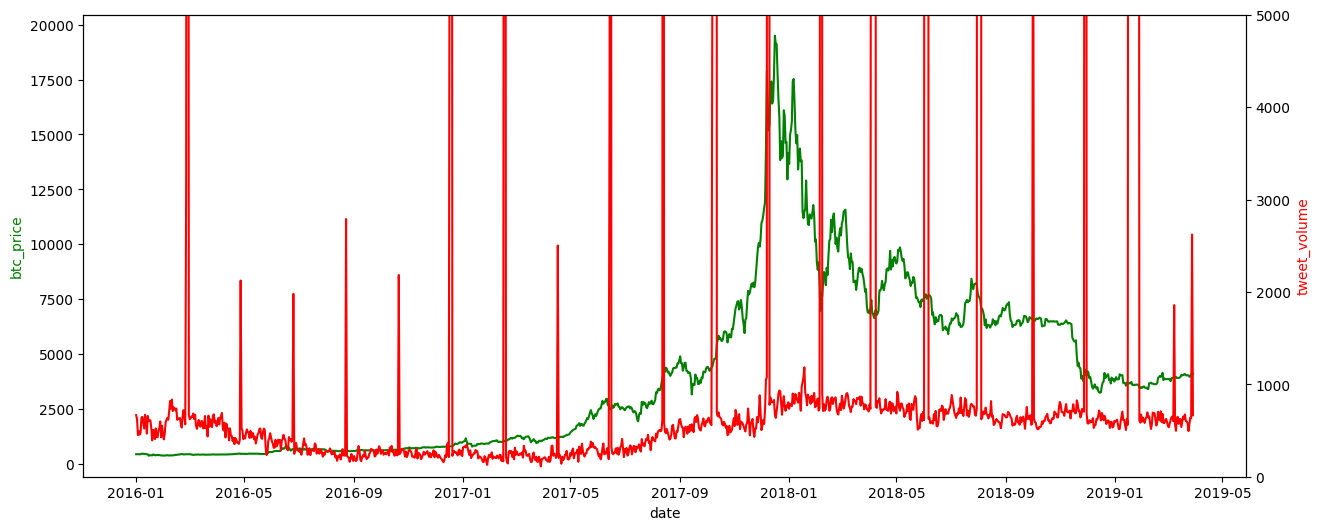

In [18]:
price_tweet = df[['date', 'btc_price', 'text']].groupby(['date', 'btc_price']).count().reset_index()
price_tweet.columns = ['date', 'btc_price', 'tweet_volume']

fig, ax1 = plt.subplots(figsize=(15, 6))

ax2 = ax1.twinx()
ax1.plot(price_tweet['date'], price_tweet['btc_price'], 'g-')
ax2.plot(price_tweet['date'], price_tweet['tweet_volume'], 'r-')

ax1.set_xlabel('date')
ax1.set_ylabel('btc_price', color='g')
ax2.set_ylabel('tweet_volume', color='r')
ax2.set_ylim(top=5000, bottom=0)

plt.show()


# plt.figure(figsize=(15,6))
# plt.plot(price_volume['date'], price_volume['btc_price'], color='green')
# plt.xlabel('date')
# plt.ylabel('btc_price (USD)')
# plt.title('Trend for BTC Price (USD)')

On the right side of the above plot, we can see that the fluctuation in tweet volume is similar as fluctuation in price at some points in the graph.

Let us prepare the data features so that we can process it using any ML model to predict the change or price of Bitcoin. We will aggregate features at day level. We will choose features similar to what we have plotted in previous steps. 

In [19]:
processed = df[['date', 'day', 'btc_price']].groupby(['date', 'day', 'btc_price']).count().reset_index()

# Joining Tweet Volume
processed = processed.join(tweet_volume.set_index('date'), on='date', validate='1:1')

# Joining likes Volume
processed = processed.join(likes_volume.set_index('date'), on='date', validate='1:1')

# Retweet Counts >0 and >1000
retweet_volume = df[['date', 'retweets']]
retweet_volume['retweets_gt_0'] = np.where(retweet_volume["retweets"]>0,1,0)
retweet_volume['retweets_gt_1000'] = np.where(retweet_volume["retweets"]>1000,1,0)
retweet_volume = retweet_volume[
    ['date', 'retweets_gt_0', 'retweets_gt_1000']
].groupby(
    ['date']
).agg({
       'retweets_gt_0':'sum',
       'retweets_gt_1000':'sum'
    }).reset_index()
processed = processed.join(retweet_volume.set_index('date'), on='date', validate='1:1')

# Number of Positive, Negative and Neutral Sentiments.
processed = processed.join(sent_volume.set_index('date'), on='date', validate='1:1')

# Number of distinct users tweeted per day
user_volume = df[['date', 'user']].groupby('date')['user'].nunique().reset_index()
processed = processed.join(user_volume.set_index('date'), on='date', validate='1:1')

# Tweet volume during certain hour of the day divided into the 4 buckets 0-6, 6-12, 12-18, 18-24
hr_volume = df[['date', 'hour']]
hr_volume['hr_0_6'] = np.where(hr_volume["hour"]<6, 1, 0)
hr_volume['hr_6_12'] = np.where((hr_volume["hour"]>=6) & (hr_volume["hour"]<12), 1, 0)
hr_volume['hr_12_18'] = np.where((hr_volume["hour"]>=12) & (hr_volume["hour"]<18), 1, 0)
hr_volume['hr_18_24'] = np.where((hr_volume["hour"]>=18) & (hr_volume["hour"]<24), 1, 0)
hr_volume = hr_volume[
    ['date', 'hr_0_6', 'hr_6_12', 'hr_12_18', 'hr_18_24']
].groupby(
    ['date']
).agg({
       'hr_0_6':'sum',
       'hr_6_12':'sum',
       'hr_12_18': 'sum',
       'hr_18_24': 'sum'
    }).reset_index()
hr_volume.head()
processed = processed.join(hr_volume.set_index('date'), on='date', validate='1:1')

# One-hot encoding the day of the week.
day_oh = pd.get_dummies(processed['day'])
processed = processed.drop('day',axis = 1)
processed = processed.join(day_oh)

# Extracting cur day price as btc_cur_price
# The regression models will try to predict next day price btc_price
# The classification model will try to predict increase (1) or decrease (0) in next day price.
processed['btc_cur_price'] = processed['btc_price']
processed['btc_price'] = processed['btc_price'].shift(periods=-1)
processed = processed.dropna().reset_index(drop=True)

In [20]:
processed.head()

,date,btc_price,tweet_volume,likes_gt_0,likes_gt_10,likes_gt_100,likes_gt_1000,retweets_gt_0,retweets_gt_1000,pos_sent,...,hr_12_18,hr_18_24,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,btc_cur_price
0,2016-01-01,433.437988,666,31,0,0,0,212,0,157,...,176,186,1,0,0,0,0,0,0,434.334015
1,2016-01-02,430.010986,625,25,2,0,0,216,0,159,...,134,138,0,0,1,0,0,0,0,433.437988
2,2016-01-03,433.091003,451,20,0,0,0,162,0,149,...,100,124,0,0,0,1,0,0,0,430.010986
3,2016-01-04,431.959991,493,22,1,0,0,143,0,151,...,115,132,0,1,0,0,0,0,0,433.091003
4,2016-01-05,429.105011,455,22,0,0,0,115,0,146,...,118,112,0,0,0,0,0,1,0,431.959991


In [21]:
processed.shape

(1183, 25)

In [22]:
processed.to_csv('../data/processed_reg_data.csv', index=False)

We have stored the above processed data into CSV format so that we can use it for regression and classification purposes.

At last, let us visualize the histograms of the features which may give us some information about distribution of data.

In [23]:
processed.columns

Index(['date', 'btc_price', 'tweet_volume', 'likes_gt_0', 'likes_gt_10',
       'likes_gt_100', 'likes_gt_1000', 'retweets_gt_0', 'retweets_gt_1000',
       'pos_sent', 'neg_sent', 'neu_sent', 'user', 'hr_0_6', 'hr_6_12',
       'hr_12_18', 'hr_18_24', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'btc_cur_price'],
      dtype='object')

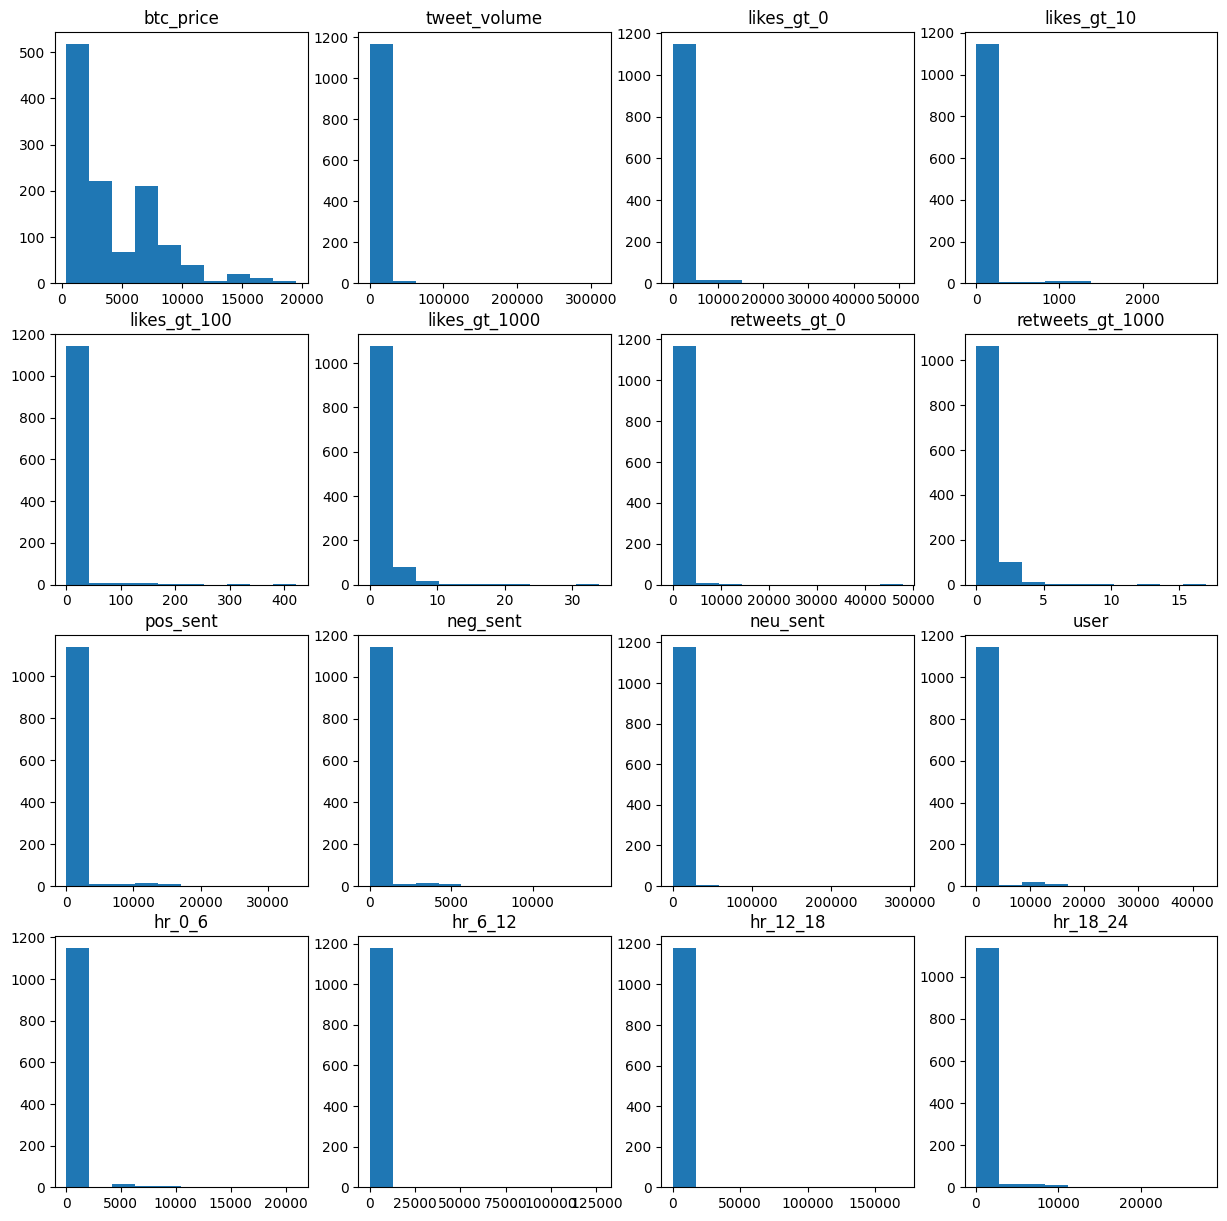

In [24]:
hist_cols = ['btc_price', 'tweet_volume', 'likes_gt_0', 'likes_gt_10',
       'likes_gt_100', 'likes_gt_1000', 'retweets_gt_0', 'retweets_gt_1000',
       'pos_sent', 'neg_sent', 'neu_sent', 'user', 'hr_0_6', 'hr_6_12',
       'hr_12_18', 'hr_18_24']

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
counter = 0

for i in range(4):
    for j in range(4):
        axs[i][j].hist(processed[hist_cols[counter]])
        axs[i][j].set_title(hist_cols[counter])
        counter += 1

You can see that most of the attributes have skewed distribution. Most of the rows in dataset have smaller values for most attributes and only some rows have extreme values